데이터 준비와 확인

In [98]:
import pandas as pd
import torch.nn as nn
import matplotlib as plt
import torch
import numpy as np
import os
import torch.nn.functional as F

# 데이터를 읽어봅시다.
train_data = pd.read_table('~/work/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/work/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


데이터로더 구성

In [99]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab("C:/Users/user/anaconda3/envs/aiffel/Library/lib/mecab/dic/mecab-ko-dic")
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any')
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [100]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [101]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

모델 구성을 위한 데이터 분석 및 가공

In [102]:
#문데이터셋 내 문장 길이 분포
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다.
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.971019612059036
문장길이 최대 :  116
문장길이 표준편차 :  12.844062009473816


In [103]:
#적절한 최대 문장 길이 지정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

pad_sequences maxlen :  41
전체 문장의 0.9342629991962691%가 maxlen 설정값 이내에 포함됩니다. 


In [104]:
#torch.nn.utils.rnn.pad_sequence을 활용한 패딩 추가
def pad_sequences(data, maxlen):
    padded_data = []
    for sentence in data:
        if len(sentence) < maxlen:
            sentence = sentence + [0] * (maxlen - len(sentence))
        else:
            sentence = sentence[:maxlen]
        padded_data.append(sentence)
    return np.array(padded_data)

x_train_padded = pad_sequences(X_train, maxlen)
x_test_padded = pad_sequences(X_test, maxlen)

x_train_tensor = torch.tensor(x_train_padded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test_padded, dtype=torch.long)

print(x_train_tensor.shape)

torch.Size([146182, 41])


모델 구성 및 validation set 구성

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [106]:
class Model_RNN(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        
        self.rnn = nn.RNN(word_vector_dim, 8, batch_first=True) # 기본 RNN 레이어 사용
        
        self.fc1 = nn.Linear(8, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        rnn_out, h_n = self.rnn(x) 
        x = h_n[-1] 
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [107]:
class Model_LSTM(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.lstm = nn.LSTM(word_vector_dim, 8, batch_first=True)   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
        self.fc1 = nn.Linear(8, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, (h_n, c_n) = self.lstm(x)
        x = h_n[-1]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [108]:
#1D CNN
class Model_CNN(nn.Module):
    def __init__(self, vocab_size, word_vector_dim):
        super(Model_CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, word_vector_dim)
        self.conv1 = nn.Conv1d(word_vector_dim, 16, kernel_size=7)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=7)
        self.pool = nn.MaxPool1d(5)
        self.global_max_pooling = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(16, 8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8, 1)    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1) # (batch, seq_len, emb_dim) -> (batch, emb_dim, seq_len)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.global_max_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [109]:
word_vector_dim = 4
model_rnn = Model_RNN(vocab_size, word_vector_dim)
print(model_rnn)

model_lstm = Model_LSTM(vocab_size, word_vector_dim)
print(model_lstm)

model_cnn = Model_CNN(vocab_size, word_vector_dim)
print(model_cnn)

Model_RNN(
  (embedding): Embedding(10000, 4)
  (rnn): RNN(4, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Model_LSTM(
  (embedding): Embedding(10000, 4)
  (lstm): LSTM(4, 8, batch_first=True)
  (fc1): Linear(in_features=8, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Model_CNN(
  (embedding): Embedding(10000, 4)
  (conv1): Conv1d(4, 16, kernel_size=(7,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(7,), stride=(1,))
  (pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (global_max_pooling): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [110]:
# validation set 10000건 분리
x_val = x_train_tensor[:10000]
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train_tensor[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

torch.Size([136182, 41])
(136182,)


In [111]:
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
loss_fn = torch.nn.BCELoss()

partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
partial_y_train_tensor = torch.tensor(partial_y_train, dtype=torch.float)

x_val_tensor = torch.tensor(x_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.float)

train_dataset = TensorDataset(partial_x_train_tensor, partial_y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)

epochs = 50   # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다.
train_losses = []
val_losses = []
train_accs = []
val_accs = []

C:\Users\user\AppData\Local\Temp\ipykernel_10092\548740234.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  partial_x_train_tensor = torch.tensor(partial_x_train, dtype=torch.long)
C:\Users\user\AppData\Local\Temp\ipykernel_10092\548740234.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val, dtype=torch.long)


모델 훈련 개시

In [112]:
#RNN 모델

optimizer = optim.Adam(model_rnn.parameters())
for epoch in range(epochs):
    model_rnn.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model_rnn(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model_rnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_rnn(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model_rnn.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_rnn(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

Epoch 1/50 - Train Loss: 0.6929, Train Accuracy: 0.5038 - Validation Loss: 0.6925, Validation Accuracy: 0.5086
Epoch 2/50 - Train Loss: 0.6928, Train Accuracy: 0.5041 - Validation Loss: 0.6924, Validation Accuracy: 0.5024
Epoch 3/50 - Train Loss: 0.6927, Train Accuracy: 0.5033 - Validation Loss: 0.6923, Validation Accuracy: 0.5067
Epoch 4/50 - Train Loss: 0.6924, Train Accuracy: 0.5039 - Validation Loss: 0.6922, Validation Accuracy: 0.5097
Epoch 5/50 - Train Loss: 0.6830, Train Accuracy: 0.5579 - Validation Loss: 0.6750, Validation Accuracy: 0.5904
Epoch 6/50 - Train Loss: 0.6699, Train Accuracy: 0.5994 - Validation Loss: 0.6565, Validation Accuracy: 0.6310
Epoch 7/50 - Train Loss: 0.6692, Train Accuracy: 0.5902 - Validation Loss: 0.6730, Validation Accuracy: 0.5738
Epoch 8/50 - Train Loss: 0.6616, Train Accuracy: 0.6106 - Validation Loss: 0.6527, Validation Accuracy: 0.6438
Epoch 9/50 - Train Loss: 0.6578, Train Accuracy: 0.6271 - Validation Loss: 0.6629, Validation Accuracy: 0.6234
E

Loss, Accuracy 그래프 시각화

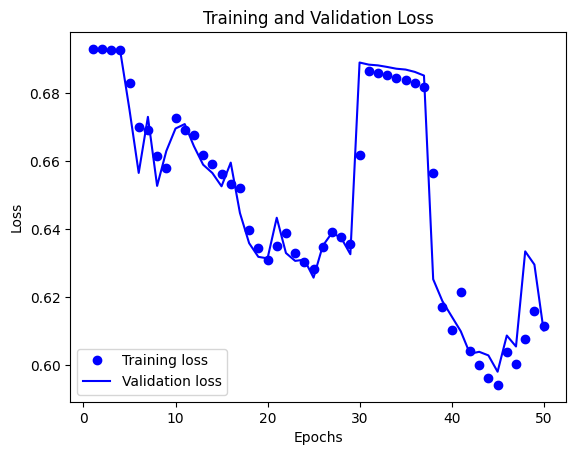

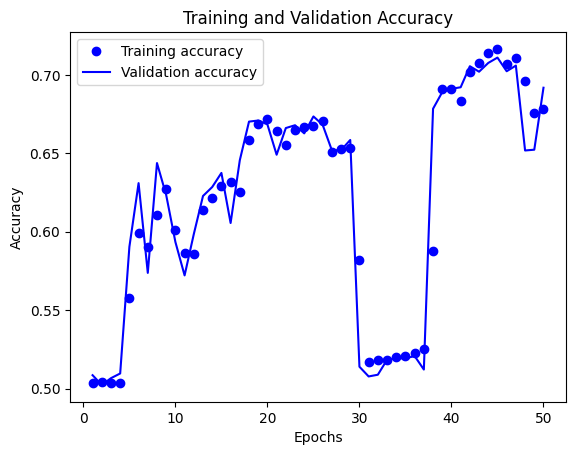

In [113]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/50 - Train Loss: 0.6929, Train Accuracy: 0.5033 - Validation Loss: 0.6927, Validation Accuracy: 0.5026
Epoch 2/50 - Train Loss: 0.6892, Train Accuracy: 0.5233 - Validation Loss: 0.6686, Validation Accuracy: 0.6164
Epoch 3/50 - Train Loss: 0.6589, Train Accuracy: 0.6295 - Validation Loss: 0.6478, Validation Accuracy: 0.6449
Epoch 4/50 - Train Loss: 0.6494, Train Accuracy: 0.6390 - Validation Loss: 0.6456, Validation Accuracy: 0.6248
Epoch 5/50 - Train Loss: 0.6420, Train Accuracy: 0.6523 - Validation Loss: 0.6506, Validation Accuracy: 0.6430
Epoch 6/50 - Train Loss: 0.6433, Train Accuracy: 0.6482 - Validation Loss: 0.6360, Validation Accuracy: 0.6488
Epoch 7/50 - Train Loss: 0.6409, Train Accuracy: 0.6519 - Validation Loss: 0.6511, Validation Accuracy: 0.6238
Epoch 8/50 - Train Loss: 0.6401, Train Accuracy: 0.6474 - Validation Loss: 0.6350, Validation Accuracy: 0.6692
Epoch 9/50 - Train Loss: 0.6332, Train Accuracy: 0.6710 - Validation Loss: 0.6269, Validation Accuracy: 0.6787
E

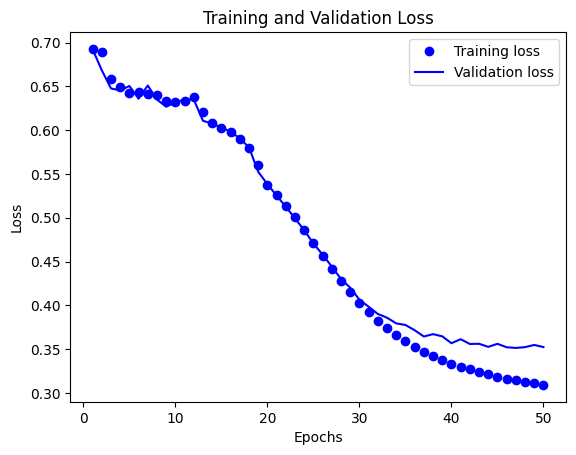

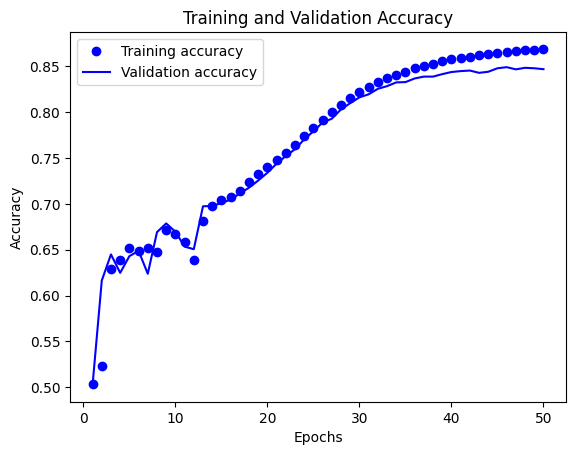

In [114]:
#LSTM 모델

optimizer = optim.Adam(model_lstm.parameters())

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    model_lstm.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model_lstm(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model_lstm.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_lstm(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

model_lstm.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_lstm(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)
plt.clf()
# "bo"는 "파란색 점"입니다
plt.plot(epochs_range, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Epoch 1/50 - Train Loss: 0.2673, Train Accuracy: 0.8915 - Validation Loss: 0.3888, Validation Accuracy: 0.8403
Epoch 2/50 - Train Loss: 0.2663, Train Accuracy: 0.8920 - Validation Loss: 0.3902, Validation Accuracy: 0.8385
Epoch 3/50 - Train Loss: 0.2653, Train Accuracy: 0.8929 - Validation Loss: 0.3909, Validation Accuracy: 0.8376
Epoch 4/50 - Train Loss: 0.2643, Train Accuracy: 0.8931 - Validation Loss: 0.3935, Validation Accuracy: 0.8385
Epoch 5/50 - Train Loss: 0.2631, Train Accuracy: 0.8940 - Validation Loss: 0.3984, Validation Accuracy: 0.8381
Epoch 6/50 - Train Loss: 0.2622, Train Accuracy: 0.8944 - Validation Loss: 0.3965, Validation Accuracy: 0.8393
Epoch 7/50 - Train Loss: 0.2614, Train Accuracy: 0.8949 - Validation Loss: 0.3963, Validation Accuracy: 0.8390
Epoch 8/50 - Train Loss: 0.2599, Train Accuracy: 0.8958 - Validation Loss: 0.4002, Validation Accuracy: 0.8375
Epoch 9/50 - Train Loss: 0.2593, Train Accuracy: 0.8959 - Validation Loss: 0.4026, Validation Accuracy: 0.8370
E

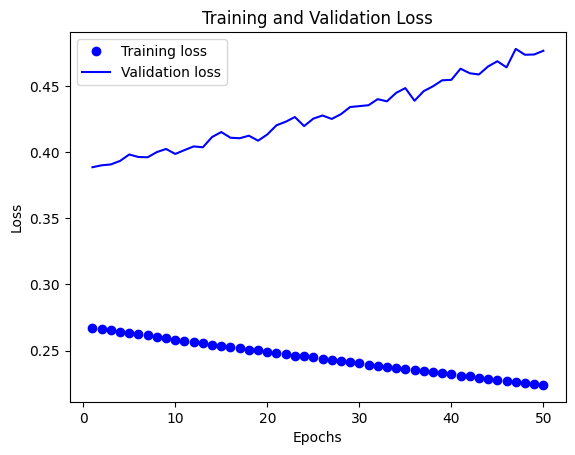

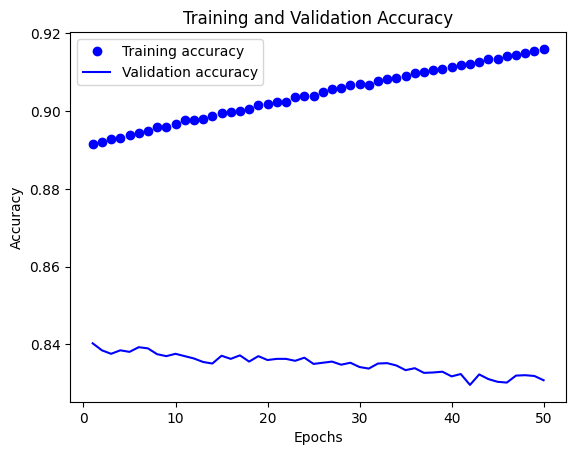

In [121]:
#CNN 모델
optimizer = optim.Adam(model_cnn.parameters())

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    model_cnn.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model_cnn(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model_cnn.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model_cnn(inputs)
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

test_dataset = TensorDataset(x_test_tensor, torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

model_cnn.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_cnn(inputs)
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")

import matplotlib.pyplot as plt

epochs_range2 = range(1, epochs + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_range2, train_losses, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_range2, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs_range2, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range2, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

학습된 Emdedding 레이어 분석

In [122]:
#gensim을 이용해서 자제학습된 혹승ㄴ 사전학습된 임벱딩 레이어 분석

In [123]:
#rnn
embedding_layer = model_rnn.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.path.join("C:/Users/user/work/sentiment_classification/word2vec_emb/word2vec_rnn.txt")

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model_rnn.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

(10000, 4)


array([-0.3150042 ,  0.87393856, -0.92527276,  0.64936876], dtype=float32)

In [124]:
#lstm
embedding_layer = model_lstm.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.path.join("C:/Users/user/work/sentiment_classification/word2vec_emb/word2vec_lstm.txt")

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model_lstm.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

(10000, 4)


array([ 0.82203513, -0.988986  ,  2.3772225 ,  0.7462934 ], dtype=float32)

In [125]:
#cnn
embedding_layer = model_cnn.embedding
weights = embedding_layer.weight.detach().cpu().numpy()

print(weights.shape)  # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
word2vec_file_path = os.path.join("C:/Users/user/work/sentiment_classification/word2vec_emb/word2vec_cnn.txt")

with open(word2vec_file_path, 'w') as f:
    f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
    vectors = model_cnn.embedding.weight.detach().cpu().numpy()
    for i in range(4, vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, vectors[i, :]))))

from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['끝']
vector

(10000, 4)


array([ 0.3158449 ,  0.60943866,  1.224131  , -0.3089385 ], dtype=float32)

한국어 Word2Vec 임베딩 활용하여 성능 개선

Epoch 1/50 - Train Loss: 0.6721, Train Accuracy: 0.5778 - Validation Loss: 0.6287, Validation Accuracy: 0.6452
Epoch 2/50 - Train Loss: 0.5944, Train Accuracy: 0.6813 - Validation Loss: 0.5569, Validation Accuracy: 0.7112
Epoch 3/50 - Train Loss: 0.5295, Train Accuracy: 0.7349 - Validation Loss: 0.5030, Validation Accuracy: 0.7509
Epoch 4/50 - Train Loss: 0.4839, Train Accuracy: 0.7667 - Validation Loss: 0.4691, Validation Accuracy: 0.7750
Epoch 5/50 - Train Loss: 0.4513, Train Accuracy: 0.7871 - Validation Loss: 0.4421, Validation Accuracy: 0.7897
Epoch 6/50 - Train Loss: 0.4274, Train Accuracy: 0.8025 - Validation Loss: 0.4230, Validation Accuracy: 0.8052
Epoch 7/50 - Train Loss: 0.4084, Train Accuracy: 0.8131 - Validation Loss: 0.4100, Validation Accuracy: 0.8117
Epoch 8/50 - Train Loss: 0.3943, Train Accuracy: 0.8220 - Validation Loss: 0.4040, Validation Accuracy: 0.8172
Epoch 9/50 - Train Loss: 0.3824, Train Accuracy: 0.8290 - Validation Loss: 0.3916, Validation Accuracy: 0.8246
E

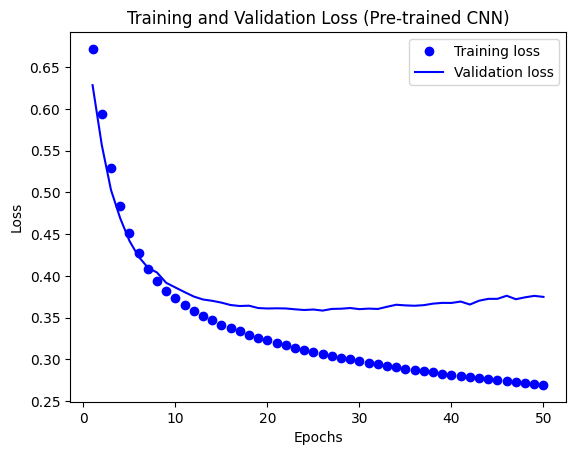

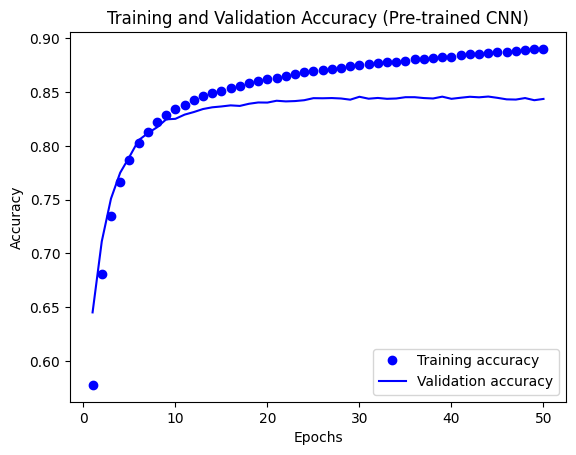

In [126]:
model_cnn_pretrained = Model_CNN(vocab_size, word_vector_dim)

pre_trained_wv = Word2VecKeyedVectors.load_word2vec_format("C:/Users/user/work/sentiment_classification/word2vec_emb/word2vec_cnn.txt", binary=False)

embedding_matrix = torch.randn((vocab_size, word_vector_dim))

model_cnn_pretrained.embedding.weight.data.copy_(embedding_matrix)

loss_fn = nn.BCELoss()  # 기존에 사용하던 loss_fn 사용

optimizer = optim.Adam(model_cnn_pretrained.parameters())

train_losses = []
train_accs = []
val_losses = []
val_accs = []


for epoch in range(epochs):
    model_cnn_pretrained.train()  # 모델을 학습 모드로 설정
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

       
        outputs = model_cnn_pretrained(inputs) # model_cnn_pretrained 사용
        
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(correct / total)

    model_cnn_pretrained.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
        
            outputs = model_cnn_pretrained(inputs) # model_cnn_pretrained 사용
            loss = loss_fn(outputs.squeeze(), labels)

            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accs[-1]:.4f} - "
          f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accs[-1]:.4f}")

print("Training Finished.")


model_cnn_pretrained.eval()  # 모델을 평가 모드로 설정
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:

        outputs = model_cnn_pretrained(inputs) # model_cnn_pretrained 사용
        loss = loss_fn(outputs.squeeze(), labels)

        test_loss += loss.item()
        predicted = (outputs.squeeze() > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print("--- Pre-trained CNN Model Test Result ---")
print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_correct / test_total:.4f}")


epochs_range1 = range(1, epochs + 1)
plt.clf()
plt.plot(epochs_range1, train_losses, 'bo', label='Training loss')
plt.plot(epochs_range1, val_losses, 'b', label='Validation loss')
plt.title('Training and Validation Loss (Pre-trained CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf() 
plt.plot(epochs_range1, train_accs, 'bo', label='Training accuracy')
plt.plot(epochs_range1, val_accs, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy (Pre-trained CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()